In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('data/training_variants')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("data/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [3]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


There are 4 fields above:
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>
    


In [4]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [6]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [7]:
# Clecking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

Now lets explore about data_text

In [8]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


So above dataset have 2 columns. ID and Text column. We can also observe column ID which is common in both the dataset.

In [9]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [10]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [11]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [12]:
# checking the dimentions
data_text.shape

(3321, 2)

In [13]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

This is descrete data so it is ***classification*** problem and since there are multiple descrete output possible so we can call it ***Multi class*** classification problem

In [14]:
# remove all stop words like a, is, an, the, ... 
# so collecting all of them from nltk library
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [15]:
import re
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [16]:
#Text processing
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Let's merge both the dataset. ID was common column. So lets use it to merge.

In [17]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [18]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


missing data is imupted by merging Gene and Variation column.

In [19]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [20]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


## Creating Training, Test and Validation data

In [21]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [22]:
from sklearn.model_selection import train_test_split
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [23]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Let's look at the distribution of data in train, test and validation set.

In [24]:
train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

In [25]:
train_class_distribution

7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64

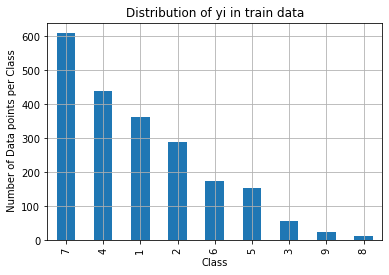

In [26]:
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

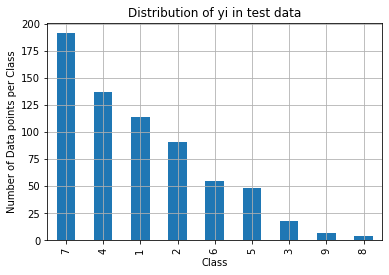

In [27]:
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

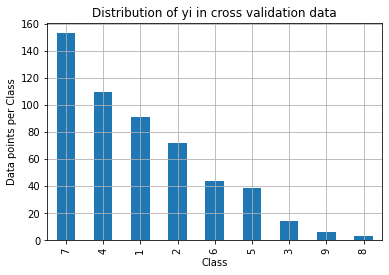

In [28]:
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

## Evaluating Gene Column


In [29]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 234
BRCA1     165
TP53       97
PTEN       85
BRCA2      84
EGFR       79
BRAF       60
KIT        58
ERBB2      47
ALK        43
PDGFRA     42
Name: Gene, dtype: int64


In [30]:
unique_genes.shape[0]

234

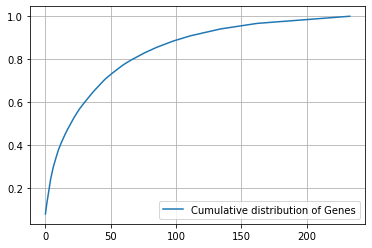

In [31]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Need to convert these categorical variable to appropirate format which my machine learning algorithm will be able to take as an input.


### One hot encoding

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [33]:
train_gene_feature_onehotCoding.shape

(2124, 233)

In [34]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 '

### Response encoding 

In [35]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [36]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

 We must be having 9 columns for Gene column after response encoding.

In [121]:
train_gene_feature_responseCoding.shape

(2124, 9)

## Evaluating Variation column

In [38]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1927
Truncating_Mutations    59
Amplification           52
Deletion                39
Fusions                 24
Overexpression           6
Q61R                     3
T58I                     3
M1R                      2
Q61K                     2
E542K                    2
Name: Variation, dtype: int64


comulative distribution of unique ***variation*** values

[0.02777778 0.05225989 0.07062147 ... 0.99905838 0.99952919 1.        ]


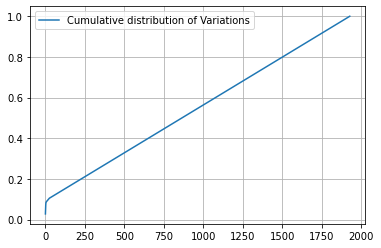

In [39]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [40]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [41]:
train_variation_feature_onehotCoding.shape

(2124, 1957)

In [42]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [43]:
train_variation_feature_responseCoding.shape

(2124, 9)

## Evaluating Text column

In [44]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word
from collections import Counter, defaultdict
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [45]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [46]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53963


In [47]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [48]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [49]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [50]:
from sklearn.preprocessing import normalize
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [51]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [52]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5950, 4: 3665, 5: 2991, 6: 2781, 9: 2142, 8: 1994, 7: 1879, 10: 1460, 12: 1279, 11: 1123, 13: 964, 14: 884, 15: 859, 16: 814, 21: 760, 18: 726, 20: 595, 17: 569, 24: 509, 19: 469, 22: 441, 26: 368, 28: 362, 30: 361, 25: 360, 23: 360, 32: 354, 27: 331, 43: 324, 29: 278, 52: 271, 36: 263, 34: 256, 33: 253, 31: 250, 42: 241, 45: 235, 35: 233, 37: 217, 40: 206, 48: 200, 39: 196, 44: 173, 54: 164, 38: 163, 55: 155, 41: 154, 56: 152, 46: 151, 63: 148, 49: 148, 51: 143, 50: 142, 64: 134, 57: 132, 47: 124, 61: 123, 60: 123, 53: 115, 58: 111, 65: 105, 72: 104, 62: 102, 66: 101, 59: 100, 70: 98, 80: 97, 67: 97, 68: 94, 90: 93, 84: 90, 73: 88, 69: 85, 88: 84, 76: 84, 78: 79, 77: 79, 85: 77, 75: 76, 81: 74, 87: 71, 74: 71, 71: 70, 104: 69, 111: 68, 91: 67, 82: 66, 79: 66, 105: 65, 86: 62, 95: 61, 89: 61, 93: 59, 102: 58, 99: 58, 92: 58, 83: 58, 100: 57, 108: 55, 98: 55, 97: 55, 135: 53, 126: 53, 94: 53, 120: 52, 106: 52, 127: 51, 110: 50, 103: 50, 96: 50, 128: 49, 101: 49, 112: 48, 107

## Combining all 3 features together

In [54]:
from scipy.sparse import hstack
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [55]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56153)
(number of data points * number of features) in test data =  (665, 56153)
(number of data points * number of features) in cross validation data = (532, 56153)


In [56]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building Machine Learning model

# Naive Bayes

In [57]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

C:\Users\v6siv\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


for alpha = 1e-05
Log Loss : 1.305798227607364
for alpha = 0.0001
Log Loss : 1.3050972761299606
for alpha = 0.001
Log Loss : 1.2956121671705005
for alpha = 0.1
Log Loss : 1.270949956391674
for alpha = 1
Log Loss : 1.308888982711751
for alpha = 10
Log Loss : 1.4286656195307486
for alpha = 100
Log Loss : 1.4094974212013294
for alpha = 1000
Log Loss : 1.3051657551277969


In [58]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.2475955798842255
for alpha = 0.0001
Log Loss : 1.2475944974167166
for alpha = 0.001
Log Loss : 1.2475836771093165
for alpha = 0.1
Log Loss : 1.246914718436831
for alpha = 1
Log Loss : 1.247230763610373
for alpha = 10
Log Loss : 1.2811260812541612
for alpha = 100
Log Loss : 1.2916608339591233
for alpha = 1000
Log Loss : 1.2931435079822962


In [59]:
#Incase of naive_bayes, one hot coding is giving best performance
best_alpha = 0.1
clf = MultinomialNB(alpha=best_alpha)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])

Log Loss : 1.270949956391674
Number of missclassified point : 0.40037593984962405


In [60]:
from sklearn import metrics
y_pred = clf.predict(test_x_onehotCoding)
cr = metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
1,0.579832,0.605263,0.592275,114.000000
2,0.544304,0.472527,0.505882,91.000000
3,0.321429,0.500000,0.391304,18.000000
4,0.723404,0.496350,0.588745,137.000000
5,0.402778,0.604167,0.483333,48.000000
6,0.688889,0.563636,0.620000,55.000000
7,0.685446,0.764398,0.722772,191.000000
8,0.375000,0.750000,0.500000,4.000000
9,0.857143,0.857143,0.857143,7.000000
accuracy,0.607519,0.607519,0.607519,0.607519


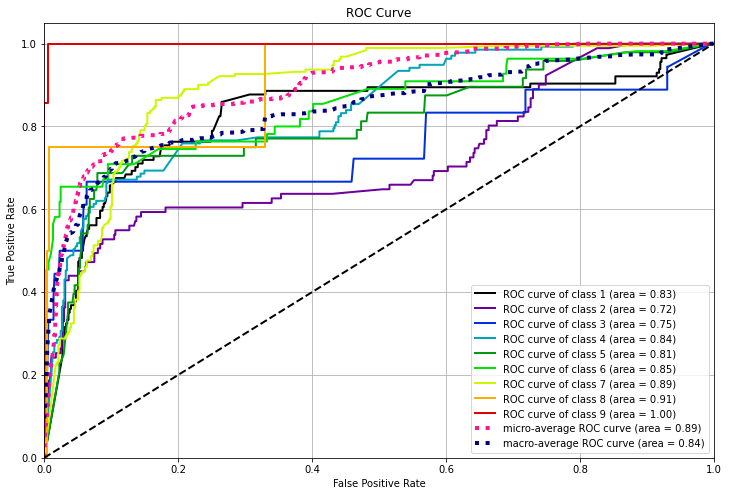

In [61]:
import scikitplot as skplt
y_true = y_test
y_probas = sig_clf.predict_proba(test_x_onehotCoding)
skplt.metrics.plot_roc(y_true, y_probas, 
                             title = 'ROC Curve',
                             figsize = (12,8))
plt.grid(b = 'Whitegrid')

# K Nearest Neighbour Classification

In [62]:
from sklearn.neighbors import KNeighborsClassifier
alpha = [1,3,5, 7,9,11,13, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1
Log Loss : 1.3270086815405011
for alpha = 3
Log Loss : 1.081212578295563
for alpha = 5
Log Loss : 1.0420165514671655
for alpha = 7
Log Loss : 1.0311863598537712
for alpha = 9
Log Loss : 1.0328343308493684
for alpha = 11
Log Loss : 1.0310848018856307
for alpha = 13
Log Loss : 1.0302032795670986
for alpha = 15
Log Loss : 1.032002149122712
for alpha = 21
Log Loss : 1.042749932022227
for alpha = 31
Log Loss : 1.0632499545334084
for alpha = 41
Log Loss : 1.0683455973756648
for alpha = 51
Log Loss : 1.0657922245792901
for alpha = 99
Log Loss : 1.0799294598982945


In [63]:
from sklearn.neighbors import KNeighborsClassifier
alpha = [1,3,5, 7,9,11,13, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1
Log Loss : 1.3944837445981537
for alpha = 3
Log Loss : 1.2927172678026686
for alpha = 5
Log Loss : 1.3243175172514614
for alpha = 7
Log Loss : 1.3275921257695944
for alpha = 9
Log Loss : 1.323859987945456
for alpha = 11
Log Loss : 1.3372396130098367
for alpha = 13
Log Loss : 1.3417805844580724
for alpha = 15
Log Loss : 1.3396983536974187
for alpha = 21
Log Loss : 1.3872268091061208
for alpha = 31
Log Loss : 1.4413731472907538
for alpha = 41
Log Loss : 1.4335869541058142
for alpha = 51
Log Loss : 1.4309825621639627
for alpha = 99
Log Loss : 1.3341128198049748


In [64]:
#Incase of KNN, response coding is giving best performance
best_alpha = 5
clf = KNeighborsClassifier(n_neighbors=best_alpha)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  5 The train log loss is: 0.4398760663735935
For values of best alpha =  5 The cross validation log loss is: 1.0420165514671655
For values of best alpha =  5 The test log loss is: 1.0426716403752976


In [65]:
y_pred = clf.predict(test_x_responseCoding)
cr = metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
1,0.597015,0.701754,0.645161,114.000000
2,0.539474,0.450549,0.491018,91.000000
3,0.350000,0.388889,0.368421,18.000000
4,0.699301,0.729927,0.714286,137.000000
5,0.454545,0.208333,0.285714,48.000000
6,0.738095,0.563636,0.639175,55.000000
7,0.694444,0.785340,0.737101,191.000000
8,0.666667,0.500000,0.571429,4.000000
9,0.666667,0.857143,0.750000,7.000000
accuracy,0.642105,0.642105,0.642105,0.642105


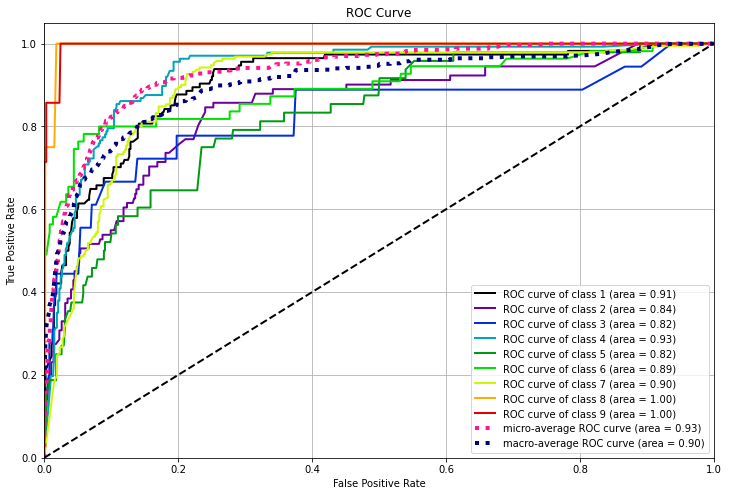

In [66]:
import scikitplot as skplt
y_true = y_test
y_probas = sig_clf.predict_proba(test_x_responseCoding)
skplt.metrics.plot_roc(y_true, y_probas, 
                             title = 'ROC Curve',
                             figsize = (12,8))
plt.grid(b = 'Whitegrid')

# Logistic Regression

### Balancing all classes

In [67]:
from sklearn.linear_model import SGDClassifier
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.391620200364039
for alpha = 1e-05
Log Loss : 1.3517349521760278
for alpha = 0.0001
Log Loss : 1.1709420878070191
for alpha = 0.001
Log Loss : 1.1462477762433612
for alpha = 0.01
Log Loss : 1.1629600731978487
for alpha = 0.1
Log Loss : 1.4450264522817613
for alpha = 1
Log Loss : 1.666718860874384
for alpha = 10
Log Loss : 1.6958235089215208
for alpha = 100
Log Loss : 1.6988732580320034


In [68]:
from sklearn.linear_model import SGDClassifier
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1e-06
Log Loss : 1.1031178124338794
for alpha = 1e-05
Log Loss : 1.027663260511963
for alpha = 0.0001
Log Loss : 1.067511224893831
for alpha = 0.001
Log Loss : 1.173440622850226
for alpha = 0.01
Log Loss : 1.2419885658231495
for alpha = 0.1
Log Loss : 1.2581215350615185
for alpha = 1
Log Loss : 1.3100256983009808
for alpha = 10
Log Loss : 1.5526211299230206
for alpha = 100
Log Loss : 1.584783656771587


In [69]:
best_alpha = 0.00001
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1e-05 The train log loss is: 0.6192593167342135
For values of best alpha =  1e-05 The cross validation log loss is: 1.027663260511963
For values of best alpha =  1e-05 The test log loss is: 1.0618135990777144


In [70]:
y_pred = clf.predict(test_x_responseCoding)
cr = metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

C:\Users\v6siv\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
1,0.589744,0.605263,0.597403,114.000000
2,0.640000,0.351648,0.453901,91.000000
3,0.190476,0.444444,0.266667,18.000000
4,0.691057,0.620438,0.653846,137.000000
5,0.431818,0.395833,0.413043,48.000000
6,0.828571,0.527273,0.644444,55.000000
7,0.642857,0.848168,0.731377,191.000000
8,0.000000,0.000000,0.000000,4.000000
9,1.000000,0.285714,0.444444,7.000000
accuracy,0.610526,0.610526,0.610526,0.610526


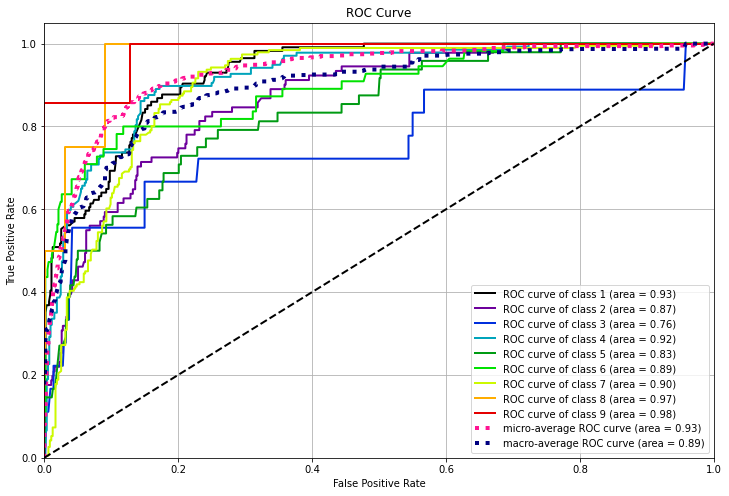

In [71]:
import scikitplot as skplt
y_true = y_test
y_probas = sig_clf.predict_proba(test_x_responseCoding)
skplt.metrics.plot_roc(y_true, y_probas, 
                             title = 'ROC Curve',
                             figsize = (12,8))
plt.grid(b = 'Whitegrid')

## Without class balancing

In [72]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.375836971620876
for alpha = 1e-05
Log Loss : 1.331817287655068
for alpha = 0.0001
Log Loss : 1.198011174264673
for alpha = 0.001
Log Loss : 1.144556126576999
for alpha = 0.01
Log Loss : 1.2191675070379926
for alpha = 0.1
Log Loss : 1.355591376041311
for alpha = 1
Log Loss : 1.573972252575292


In [73]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.0953622935818463
for alpha = 1e-05
Log Loss : 1.0291683158512783
for alpha = 0.0001
Log Loss : 1.0755221109892543
for alpha = 0.001
Log Loss : 1.1763312557429013
for alpha = 0.01
Log Loss : 1.2391995187778315
for alpha = 0.1
Log Loss : 1.2694325608967922
for alpha = 1
Log Loss : 1.3031586572549545


In [74]:
best_alpha = 0.001
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 1.0745203646691897
For values of best alpha =  0.001 The cross validation log loss is: 1.1763312557429013
For values of best alpha =  0.001 The test log loss is: 1.1677442986749518


In [75]:
y_pred = clf.predict(test_x_responseCoding)
cr = metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

C:\Users\v6siv\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
1,0.590476,0.543860,0.566210,114.000000
2,1.000000,0.043956,0.084211,91.000000
3,0.000000,0.000000,0.000000,18.000000
4,0.557789,0.810219,0.660714,137.000000
5,0.000000,0.000000,0.000000,48.000000
6,0.764706,0.236364,0.361111,55.000000
7,0.552941,0.984293,0.708098,191.000000
8,0.000000,0.000000,0.000000,4.000000
9,0.000000,0.000000,0.000000,7.000000
accuracy,0.568421,0.568421,0.568421,0.568421


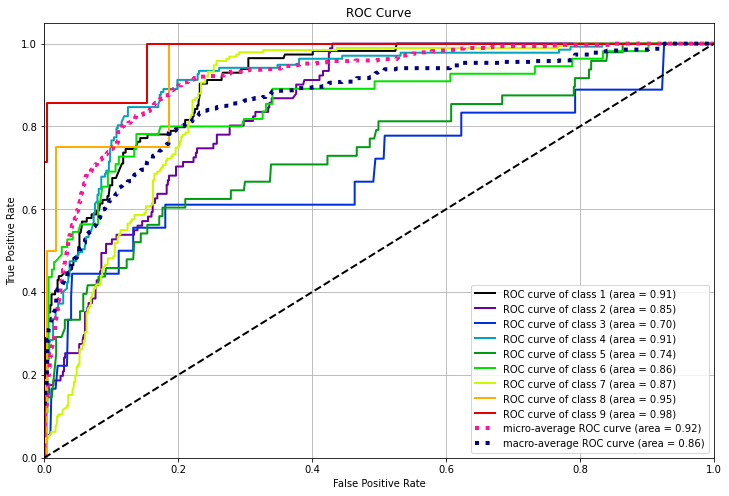

In [76]:
import scikitplot as skplt
y_true = y_test
y_probas = sig_clf.predict_proba(test_x_responseCoding)
skplt.metrics.plot_roc(y_true, y_probas, 
                             title = 'ROC Curve',
                             figsize = (12,8))
plt.grid(b = 'Whitegrid')

# Linear Support Vector Machines

In [77]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



for C = 1e-05
Log Loss : 1.3452524935410983
for C = 0.0001
Log Loss : 1.2735493328366423
for C = 0.001
Log Loss : 1.2244082651717305
for C = 0.01
Log Loss : 1.1799391311694691
for C = 0.1
Log Loss : 1.3797653678632804
for C = 1
Log Loss : 1.6846191226033178
for C = 10
Log Loss : 1.6993387294547349
for C = 100
Log Loss : 1.6993387423025113


In [78]:
alpha = [10 ** x for x in range(-7, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for C = 1e-07
Log Loss : 1.0691851001669481
for C = 1e-06
Log Loss : 1.088737357323607
for C = 1e-05
Log Loss : 1.045350818054621
for C = 0.0001
Log Loss : 1.0445499529333857
for C = 0.001
Log Loss : 1.0933783269343933
for C = 0.01
Log Loss : 1.098050741809326
for C = 0.1
Log Loss : 1.1053266853618098
for C = 1
Log Loss : 1.1048819453759933
for C = 10
Log Loss : 1.290188286876922
for C = 100
Log Loss : 1.5949580823954823


In [79]:
best_alpha = 0.01
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', best_alpha, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.01 The train log loss is: 0.714078307312555
For values of best alpha =  0.01 The cross validation log loss is: 1.1799391311694691
For values of best alpha =  0.01 The test log loss is: 1.1410244935913958


In [80]:
y_pred = clf.predict(test_x_onehotCoding)
cr = metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
1,0.627451,0.561404,0.592593,114.000000
2,0.573529,0.428571,0.490566,91.000000
3,0.300000,0.500000,0.375000,18.000000
4,0.658915,0.620438,0.639098,137.000000
5,0.444444,0.500000,0.470588,48.000000
6,0.660714,0.672727,0.666667,55.000000
7,0.677725,0.748691,0.711443,191.000000
8,0.333333,0.500000,0.400000,4.000000
9,0.666667,0.857143,0.750000,7.000000
accuracy,0.615038,0.615038,0.615038,0.615038


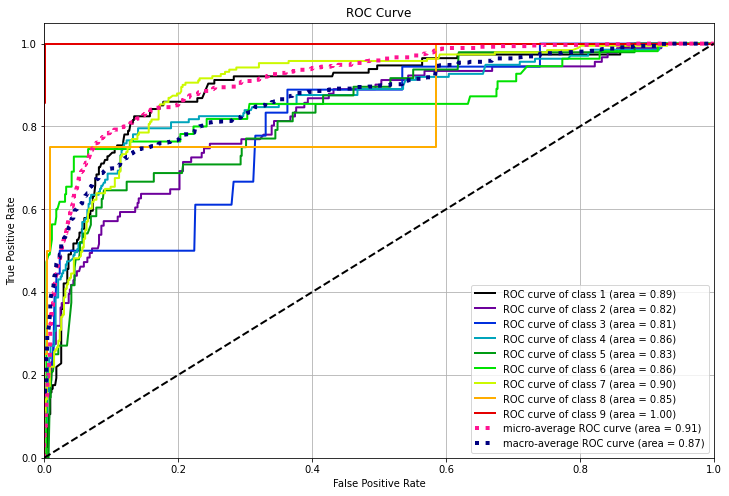

In [81]:
import scikitplot as skplt
y_true = y_test
y_probas = sig_clf.predict_proba(test_x_onehotCoding)
skplt.metrics.plot_roc(y_true, y_probas, 
                             title = 'ROC Curve',
                             figsize = (12,8))
plt.grid(b = 'Whitegrid')

# Random Forest Classifier

In [82]:
from sklearn.ensemble import RandomForestClassifier
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.2803455964487207
for n_estimators = 100 and max depth =  10
Log Loss : 1.2052593477333795
for n_estimators = 200 and max depth =  5
Log Loss : 1.2699928140264904
for n_estimators = 200 and max depth =  10
Log Loss : 1.2000850074564557
for n_estimators = 500 and max depth =  5
Log Loss : 1.2651517415799203
for n_estimators = 500 and max depth =  10
Log Loss : 1.1931170534971756
for n_estimators = 1000 and max depth =  5
Log Loss : 1.260779589642772
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1906953166172054
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2608934566787122
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1877804233598714


In [83]:
from sklearn.ensemble import RandomForestClassifier
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.3345528593885803
for n_estimators = 100 and max depth =  10
Log Loss : 1.7297776213226428
for n_estimators = 200 and max depth =  5
Log Loss : 1.3754740652354072
for n_estimators = 200 and max depth =  10
Log Loss : 1.7413987677225682
for n_estimators = 500 and max depth =  5
Log Loss : 1.4080324754426032
for n_estimators = 500 and max depth =  10
Log Loss : 1.7726213921369796
for n_estimators = 1000 and max depth =  5
Log Loss : 1.3898306682057222
for n_estimators = 1000 and max depth =  10
Log Loss : 1.7339765770938365
for n_estimators = 2000 and max depth =  5
Log Loss : 1.4107670951998341
for n_estimators = 2000 and max depth =  10
Log Loss : 1.764414758857349


In [124]:
best_estimator = 1000
clf = RandomForestClassifier(n_estimators=best_estimator, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', best_estimator, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', best_estimator, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', best_estimator, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  1000 The train log loss is: 0.6713811547060493
For values of best estimator =  1000 The cross validation log loss is: 1.1906953166172054
For values of best estimator =  1000 The test log loss is: 1.1442831039795238


In [125]:
y_pred = clf.predict(test_x_onehotCoding)
cr = metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

C:\Users\v6siv\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
1,0.544715,0.587719,0.565401,114.000000
2,0.888889,0.087912,0.160000,91.000000
3,0.000000,0.000000,0.000000,18.000000
4,0.622047,0.576642,0.598485,137.000000
5,0.533333,0.166667,0.253968,48.000000
6,0.956522,0.400000,0.564103,55.000000
7,0.515152,0.979058,0.675090,191.000000
8,0.000000,0.000000,0.000000,4.000000
9,1.000000,0.285714,0.444444,7.000000
accuracy,0.560902,0.560902,0.560902,0.560902


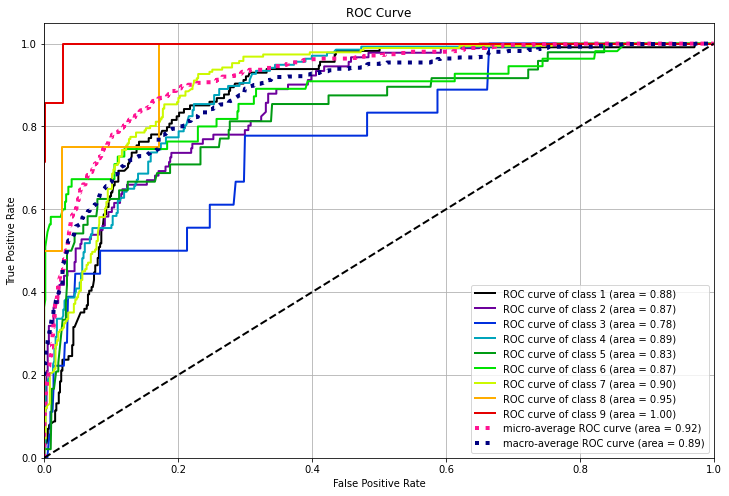

In [86]:
import scikitplot as skplt
y_true = y_test
y_probas = sig_clf.predict_proba(test_x_onehotCoding)
skplt.metrics.plot_roc(y_true, y_probas, 
                             title = 'ROC Curve',
                             figsize = (12,8))
plt.grid(b = 'Whitegrid')

# StackingClassifier

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    estimators_list = [('lr',sig_clf1), ('lsvm',sig_clf2), ('mnb',sig_clf3)]
    sclf = StackingClassifier(estimators=estimators_list, final_estimator=lr)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.15
Support vector machines : Log Loss: 1.68
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.822
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.757
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.435
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.118
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.070


C:\Users\v6siv\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.084


In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_responseCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_responseCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_responseCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")


clf4 = KNeighborsClassifier(n_neighbors=5)
clf4.fit(train_x_responseCoding, train_y)
sig_clf4 = CalibratedClassifierCV(clf4, method="sigmoid")


sig_clf1.fit(train_x_responseCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_responseCoding))))
sig_clf2.fit(train_x_responseCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_responseCoding))))
sig_clf3.fit(train_x_responseCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_responseCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    estimators_list = [('lr',sig_clf1), ('lsvm',sig_clf2), ('mnb',sig_clf3), ('knn',sig_clf4)]
    sclf = StackingClassifier(estimators=estimators_list, final_estimator=lr)
    sclf.fit(train_x_responseCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_responseCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_responseCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.17
Support vector machines : Log Loss: 1.10
Naive Bayes : Log Loss: 1.25
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.808
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.652
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.235
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.046
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.045
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.062


C:\Users\v6siv\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [114]:
lr = LogisticRegression(C=1)
estimators_list = [('lr',sig_clf1), ('lsvm',sig_clf2), ('mnb',sig_clf3), ('knn',sig_clf4)]
sclf = StackingClassifier(estimators=estimators_list, final_estimator=lr)
sclf.fit(train_x_responseCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_responseCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_responseCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_responseCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_responseCoding)- test_y))/test_y.shape[0])


Log loss (train) on the stacking classifier : 0.47567931366420635
Log loss (CV) on the stacking classifier : 1.0445170803490151
Log loss (test) on the stacking classifier : 1.034056872156069
Number of missclassified point : 0.3458646616541353


In [116]:
y_pred = clf.predict(test_x_onehotCoding)
cr = metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

C:\Users\v6siv\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
1,0.540323,0.587719,0.563025,114.000000
2,0.866667,0.142857,0.245283,91.000000
3,0.250000,0.055556,0.090909,18.000000
4,0.624000,0.569343,0.595420,137.000000
5,0.533333,0.166667,0.253968,48.000000
6,0.956522,0.400000,0.564103,55.000000
7,0.523810,0.979058,0.682482,191.000000
8,0.000000,0.000000,0.000000,4.000000
9,1.000000,0.285714,0.444444,7.000000
accuracy,0.568421,0.568421,0.568421,0.568421


# VotingClassifier

In [117]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr',sig_clf1), ('lsvm',sig_clf2), ('mnb',sig_clf3), ('knn',sig_clf4)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])


Log loss (train) on the VotingClassifier : 0.8746799560052086
Log loss (CV) on the VotingClassifier : 1.222941072370065
Log loss (test) on the VotingClassifier : 1.1910248760402864
Number of missclassified point : 0.3533834586466165


In [118]:
y_pred = clf.predict(test_x_onehotCoding)
cr = metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

C:\Users\v6siv\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
1,0.540323,0.587719,0.563025,114.000000
2,0.866667,0.142857,0.245283,91.000000
3,0.250000,0.055556,0.090909,18.000000
4,0.624000,0.569343,0.595420,137.000000
5,0.533333,0.166667,0.253968,48.000000
6,0.956522,0.400000,0.564103,55.000000
7,0.523810,0.979058,0.682482,191.000000
8,0.000000,0.000000,0.000000,4.000000
9,1.000000,0.285714,0.444444,7.000000
accuracy,0.568421,0.568421,0.568421,0.568421


Conclusions:
    <ul>
        <li>Out of all machine learning models, KNN is performing well in this case</li>
        <li>Enseble techniques does not always increase model performance</li>
    </ul>
    